# Quantifying dambos

* **Products used:** 
[gm_s2_annual](https://explorer.digitalearth.africa/gm_s2_annual)

## Description

Calculate dambo crop stats.



***
## Getting started
​
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 


In [2]:
import datacube
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from datacube.utils import geometry
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.dask import create_local_dask_cluster
from datacube.utils.cog import write_cog
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.spatial import xr_rasterize, xr_vectorize
from deafrica_tools.classification import sklearn_flatten, sklearn_unflatten

%matplotlib inline

## Create local dask cluster

In [4]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:35641 Dashboard: /user/mickwelli@bigpond.com/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


## Connect to datacube

In [5]:
dc = datacube.Datacube(app='dambo-analysis')

## Load classified images

/tmp/ipykernel_210/483430790.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  geotiff_crop = xr.open_rasterio('results/crop_prediction.tif')


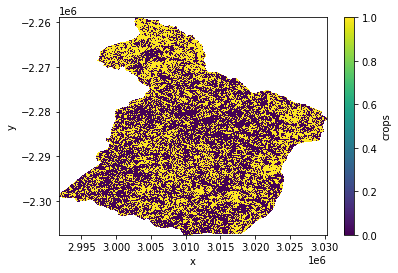

In [6]:
geotiff_crop = xr.open_rasterio('results/crop_prediction.tif')
crop_pred = geotiff_crop.to_dataset('band')
crop_pred = crop_pred.rename({1: 'crops'})

crop_pred.crops.plot()

/tmp/ipykernel_210/1441200923.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  geotiff_dambo = xr.open_rasterio('results/dambo_prediction.tif')
/env/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


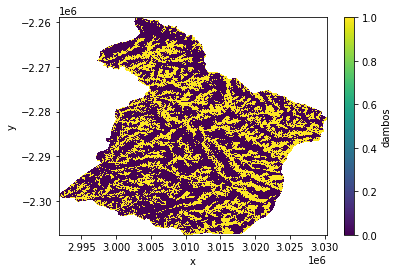

In [7]:
gdf = gpd.read_file('data/Dambo_study_area.shp')
geom = geometry.Geometry(gdf.unary_union, gdf.crs)

geotiff_dambo = xr.open_rasterio('results/dambo_prediction.tif')
dambo_pred = geotiff_dambo.to_dataset('band')
mask = xr_rasterize(gdf, dambo_pred)
dambo_pred = dambo_pred.rename({1: 'dambos'})
dambo_pred = dambo_pred.where(mask)
dambo_pred.dambos.plot()

In [8]:
crop_pred = crop_pred.assign(dambos=dambo_pred.dambos)
dambo_crops = crop_pred.assign(dambo_crops=xr.where((crop_pred.crops==1) & (dambo_pred.dambos == 1),1,np.nan))
dambo_crops = dambo_crops.assign(uplands=xr.where(dambo_pred.dambos!=1, 1, np.nan))
dambo_crops = dambo_crops.assign(upland_crops=xr.where((crop_pred.crops==1) & (dambo_pred.dambos != 1),1,np.nan))
dambo_crops = dambo_crops.where(mask)

In [9]:
write_cog(dambo_crops.to_array(), 'results/dambo_crops.tif', overwrite=True)

PosixPath('results/dambo_crops.tif')

In [10]:
dambo_crops

<xarray.Dataset>
Dimensions:       (y: 2426, x: 1928)
Coordinates:
  * y             (y) float64 -2.259e+06 -2.259e+06 ... -2.307e+06 -2.307e+06
  * x             (x) float64 2.992e+06 2.992e+06 ... 3.03e+06 3.03e+06
Data variables:
    crops         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    dambos        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    dambo_crops   (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    uplands       (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    upland_crops  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    transform:      (20.0, 0.0, 2991760.0, 0.0, -20.0, -2258960.0)
    crs:            +init=epsg:6933
    res:            (20.0, 20.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

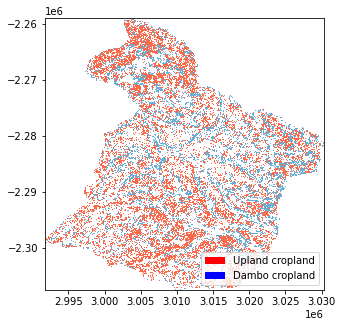

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))


dambo_crops.upland_crops.plot(
    ax=ax, cmap="Reds", add_colorbar=False, add_labels=False
)
dambo_crops.dambo_crops.plot(
    ax=ax, cmap="Blues", add_colorbar=False, add_labels=False
)
ax.legend(
    [
        Patch(facecolor='Red'),
        Patch(facecolor='Blue'),
    ],
    ["Upland cropland", "Dambo cropland"],
    loc="lower right")

plt.show();

In [12]:
m2_per_ha = 10000
m2_per_pixel = 20 ** 2

dambo_count = dambo_crops.dambos.sum().values * m2_per_pixel / m2_per_ha
upland_count = dambo_crops.uplands.sum().values * m2_per_pixel / m2_per_ha
crops_count = dambo_crops.crops.sum().values * m2_per_pixel / m2_per_ha
dambo_crops_count = dambo_crops.dambo_crops.sum().values* m2_per_pixel / m2_per_ha
upland_crops_count = dambo_crops.upland_crops.sum().values* m2_per_pixel / m2_per_ha

counts_total = {
          'Dambo area': dambo_count,
          'Upland area': upland_count
          }

df_total = pd.DataFrame(counts_total, index=['Area (Ha)']).transpose()

percentage = []
for i in range(df_total.shape[0]):
    pct = (df_total['Area (Ha)'][i]) / (df_total['Area (Ha)'].sum()) * 100
    percentage.append(round(pct,2))
df_total['Percentage'] = percentage

counts_cropped = {
          'Dambo cropped': dambo_crops_count,
          'Upland cropped': upland_crops_count
          }

df_cropped = pd.DataFrame(counts_cropped, index=['Area (Ha)']).transpose()

percentage = []
for i in range(df_cropped.shape[0]):
    pct = (df_cropped['Area (Ha)'][i]) / (df_cropped['Area (Ha)'].sum()) * 100
    percentage.append(round(pct,2))
df_cropped['Percentage'] = percentage

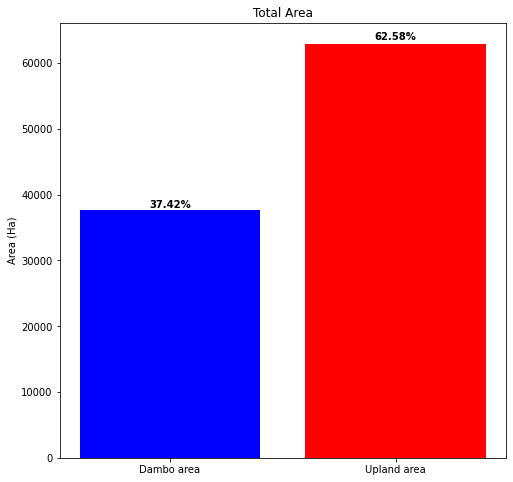

In [13]:
plt.figure(figsize=(8,8))
colors_list = ['Blue', 'Red']
graph = plt.bar(df_total.index,df_total['Area (Ha)'], color = colors_list)
plt.ylabel('Area (Ha)')
plt.title('Total Area')
 
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(df_total.Percentage[i])+'%',
             ha='center',
             weight='bold')
    i+=1
plt.show()

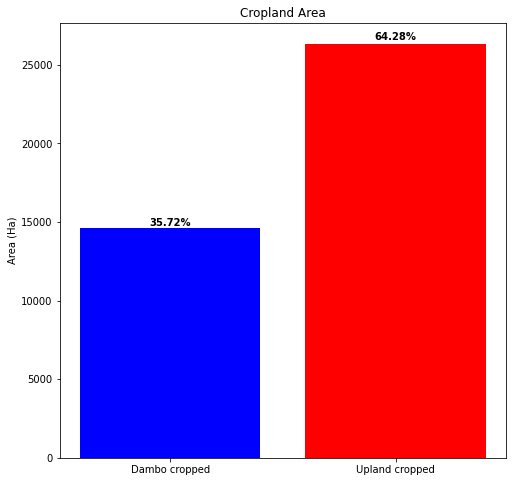

In [14]:
plt.figure(figsize=(8,8))
colors_list = ['Blue', 'Red']
graph = plt.bar(df_cropped.index,df_cropped['Area (Ha)'], color = colors_list)
plt.ylabel('Area (Ha)')
plt.title('Cropland Area')
 
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(df_cropped.Percentage[i])+'%',
             ha='center',
             weight='bold')
    i+=1
plt.show()

In [75]:
gdf = gpd.read_file('data/Dambo_study_area.shp')
geom = geometry.Geometry(gdf.unary_union, gdf.crs)
query = {
    'geopolygon': geom,
    'time': ('2018-01-01','2021-12-31'),
    'measurements': ['red', 'green', 'blue', 'nir'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:6933',
    'dask_chunks' : {'x':1000,'y':1000},
}


s2_ds = load_ard(dc=dc,
              products=['s2_l2a'],
              min_gooddata=0.99,
              **query)
    

/home/jovyan/Tools/deafrica_tools/datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 406 out of 986 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Returning 406 time steps as a dask array


In [76]:
s2_ndvi = calculate_indices(s2_ds, index=['NDVI'], drop=True, collection='s2')

Dropping bands ['red', 'green', 'blue', 'nir']


In [77]:
s2_ndvi_dambo_crops = s2_ndvi.where(dambo_crops.dambo_crops==1) 

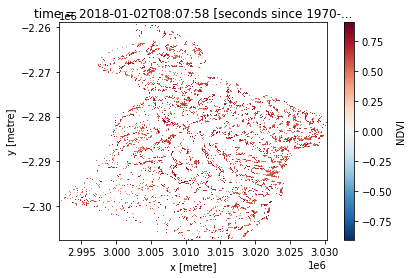

In [78]:
s2_ndvi_dambo_crops.NDVI[0].plot()

In [79]:
s2_ndvi_upland_crops = s2_ndvi.where(dambo_crops.upland_crops==1) 

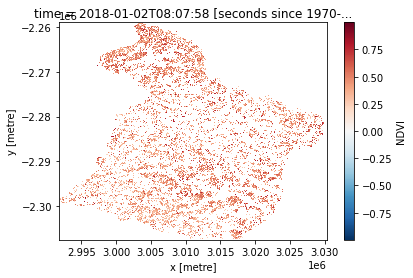

In [80]:
s2_ndvi_upland_crops.NDVI[0].plot()

## Resample to timeseries

Takes a long time to run

In [81]:
ndvi_mean_dambo = s2_ndvi_dambo_crops.resample(time='1M').mean().NDVI.mean(['x','y']).compute()
ndvi_std_dambo = s2_ndvi_dambo_crops.resample(time='1M').mean().NDVI.std(['x','y']).compute()
ndvi_mean_upland = s2_ndvi_upland_crops.resample(time='1M').mean().NDVI.mean(['x','y']).compute()
ndvi_std_upland = s2_ndvi_upland_crops.resample(time='1M').mean().NDVI.std(['x','y']).compute()

In [ ]:
ds_rf_month = dc.load(product='rainfall_chirps_monthly',
                time=('2018-01-01', '2021-12-31'),
                geopolygon = geom,
                resolution=(-5000, 5000),
                output_crs='epsg:6933')

ds_rf_month.resample(time='1M').mean().rainfall.mean(['x','y']).plot(figsize=(11, 5))

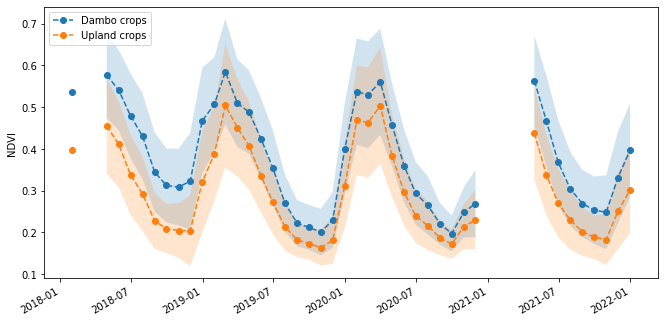

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
ndvi_mean_dambo.plot(ax=ax, label='Dambo crops', linestyle='dashed', marker='o')
ndvi_mean_upland.plot(ax=ax, label='Upland crops', linestyle='dashed', marker='o')
ax.fill_between(
    ndvi_mean_dambo.time,
    ndvi_mean_dambo-ndvi_std_dambo,
    ndvi_mean_dambo+ndvi_std_dambo,
    alpha=0.2,
)
ax.fill_between(
    ndvi_mean_upland.time,
    ndvi_mean_upland-ndvi_std_upland,
    ndvi_mean_upland+ndvi_std_upland,
    alpha=0.2,
)
plt.legend(loc="upper left")
plt.title("")
plt.xlabel("");

Text(0.5, 1.0, '')

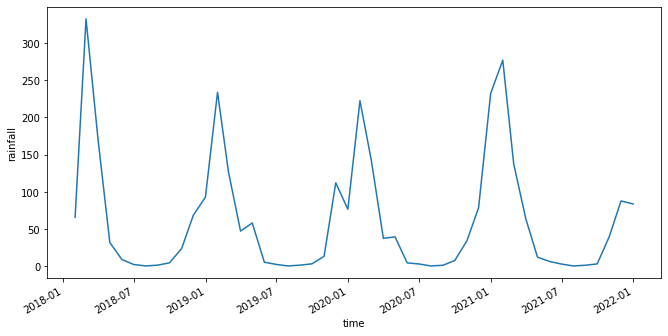

In [91]:
ds_rf_month = dc.load(product='rainfall_chirps_monthly',
                time=('2018-01-01', '2021-12-31'),
                geopolygon = geom,
                resolution=(-5000, 5000),
                output_crs='epsg:6933')

ds_rf_month.resample(time='1M').mean().rainfall.mean(['x','y']).plot(figsize=(11, 5))
plt.title("")